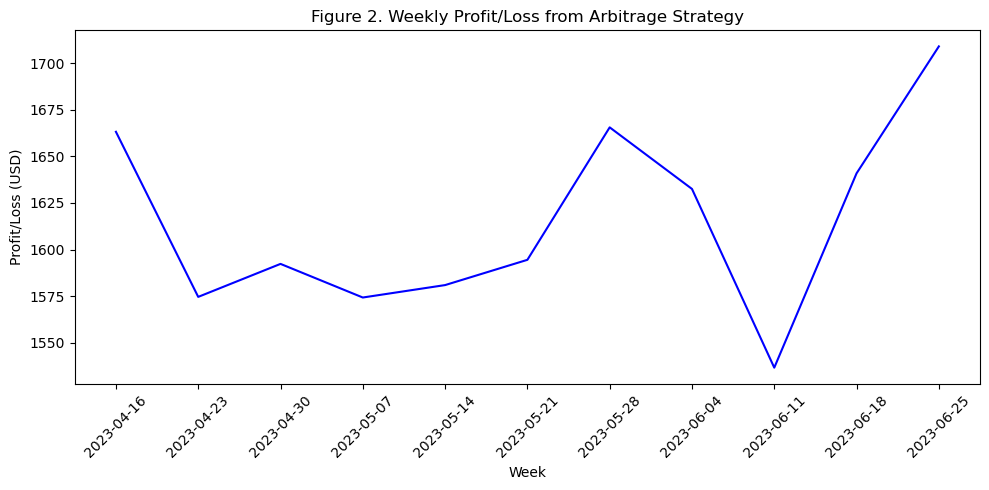

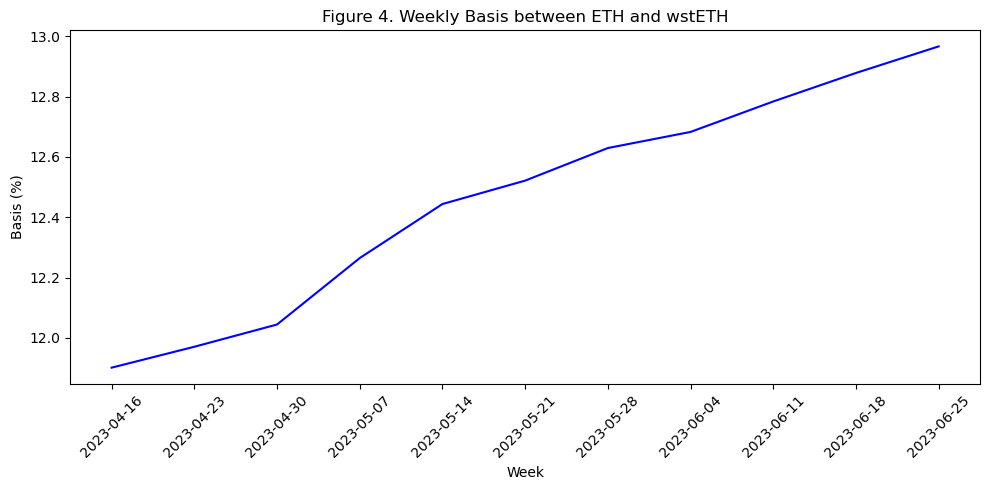

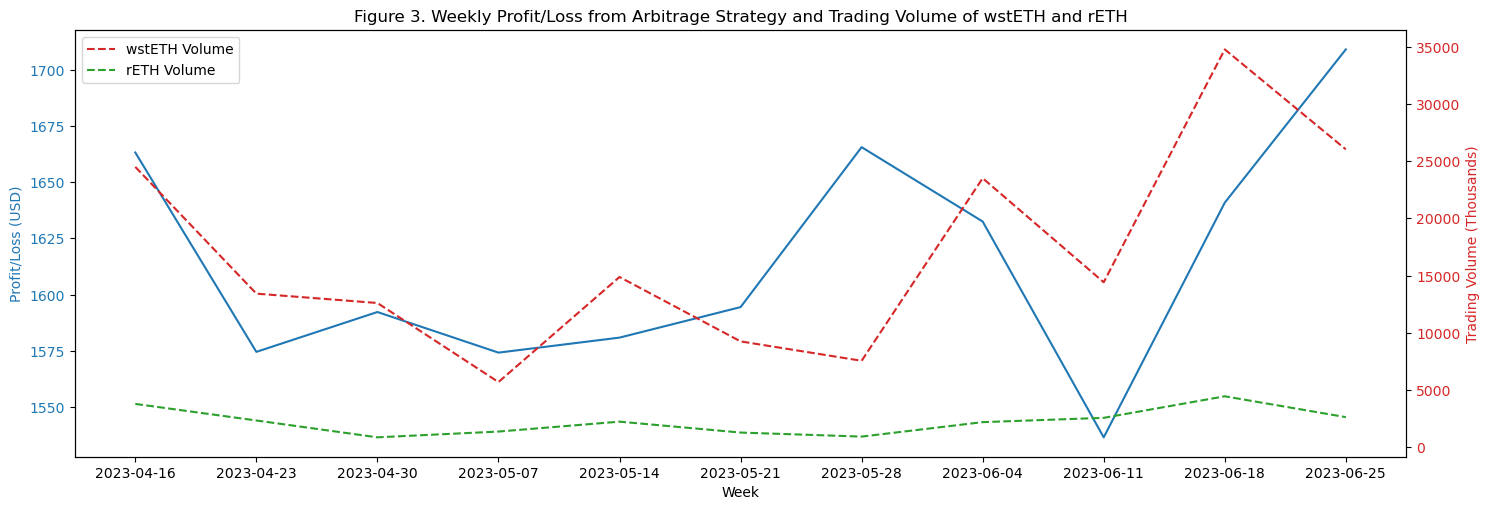

In [3]:
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict

# Load the ETH price data from a JSON file
with open('data/eth_price.json') as f:
    eth_data = json.load(f)

# Load the wstETH price data from a JSON file
with open('data/wsteth_price.json') as f:
    wsteth_data = json.load(f)

# Load the rETH price data from a JSON file
with open('data/reth_price.json') as f:
    reth_data = json.load(f)
    
# Load the gas price data from a JSON file
with open('data/gas_price.json') as f:
    gas_data = json.load(f)

# Function to calculate average daily price
def calculate_daily_average(data):
    daily_prices = defaultdict(list)
    for price_data in data['prices']:
        date = datetime.fromtimestamp(price_data[0] / 1000).strftime('%Y-%m-%d')
        price = price_data[1]
        daily_prices[date].append(price)
    daily_average = {date: sum(prices) / len(prices) for date, prices in daily_prices.items()}
    return daily_average

# Calculate average daily prices
eth_daily_average = calculate_daily_average(eth_data)
wsteth_daily_average = calculate_daily_average(wsteth_data)
reth_daily_average = calculate_daily_average(reth_data)

# Calculate daily gas cost
gas_usage = 221000  # total gas usage for the operations
daily_gas_cost = {data['Date(UTC)']: data['Value (Wei)'] * gas_usage / 1e18 for data in gas_data}  # Convert from Wei to ETH

# Calculate the weekly profit/loss
start_date = datetime(2023, 4, 16)
end_date = datetime(2023, 7, 1)  
current_date = start_date
weekly_profit = {}
while current_date < end_date:
    week_profit = 0
    for i in range(7):
        date_str = current_date.strftime('%Y-%m-%d')
        if date_str in eth_daily_average and date_str in wsteth_daily_average:
            arbitrage = wsteth_daily_average[date_str] - eth_daily_average[date_str]
            if date_str in daily_gas_cost:
                arbitrage -= daily_gas_cost[date_str]
            week_profit += arbitrage
        current_date += timedelta(days=1)
    weekly_profit[start_date.strftime('%Y-%m-%d')] = week_profit
    start_date += timedelta(days=7)

# Plot the weekly profit/loss as a line graph
plt.figure(figsize=(10, 5))
plt.plot(list(weekly_profit.keys()), list(weekly_profit.values()), color='b')
plt.xlabel('Week')
plt.ylabel('Profit/Loss (USD)')
plt.title('Figure 2. Weekly Profit/Loss from Arbitrage Strategy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate the weekly basis as a percentage
start_date = datetime(2023, 4, 16)
end_date = datetime(2023, 7, 1)  
current_date = start_date
weekly_basis = {}
while current_date < end_date:
    week_basis = 0
    for i in range(7):
        date_str = current_date.strftime('%Y-%m-%d')
        if date_str in eth_daily_average and date_str in wsteth_daily_average:
            basis = (wsteth_daily_average[date_str] - eth_daily_average[date_str]) / eth_daily_average[date_str] * 100
            week_basis += basis
        current_date += timedelta(days=1)
    weekly_basis[start_date.strftime('%Y-%m-%d')] = week_basis / 7  # Calculate the average basis for the week
    start_date += timedelta(days=7)

# Plot the weekly basis as a line graph
plt.figure(figsize=(10, 5))
plt.plot(list(weekly_basis.keys()), list(weekly_basis.values()), color='b')
plt.xlabel('Week')
plt.ylabel('Basis (%)')
plt.title('Figure 4. Weekly Basis between ETH and wstETH')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Load the wstETH volume data from a JSON file
with open('data/wstethvol.json') as f:
    wsteth_vol_data = json.load(f)

# Function to calculate average weekly volume
def calculate_weekly_average(data):
    weekly_volumes = defaultdict(list)
    for volume_data in data['total_volumes']:
        timestamp = volume_data[0]
        volume = volume_data[1]
        date = datetime.fromtimestamp(timestamp / 1000).strftime('%Y-%m-%d')
        week = datetime.strptime(date, '%Y-%m-%d').isocalendar()[1]
        weekly_volumes[week].append(volume)
    weekly_average = {week: sum(volumes) / len(volumes) for week, volumes in weekly_volumes.items()}
    return weekly_average

# Calculate average weekly volumes
wsteth_weekly_volume = calculate_weekly_average(wsteth_vol_data)

# Convert the dictionaries to lists for plotting
weeks = [week for week in weekly_profit.keys()]
week_numbers = [datetime.strptime(week, '%Y-%m-%d').isocalendar()[1] for week in weeks]
wsteth_volumes = [wsteth_weekly_volume[week_number] / 1000 for week_number in week_numbers]  

# Load the rETH volume data from a JSON file
with open('data/rETH_Vol_Data.json') as f:
    reth_vol_data = json.load(f)

# Calculate average weekly volumes
reth_weekly_volume = calculate_weekly_average(reth_vol_data)

# Convert the dictionaries to lists for plotting
reth_volumes = [reth_weekly_volume[week_number] / 1000 for week_number in week_numbers]  

# Create a new figure for the plot
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot the weekly profit/loss as a line graph
color = 'tab:blue'
ax1.set_xlabel('Week')
ax1.set_ylabel('Profit/Loss (USD)', color=color)
ax1.plot(list(weekly_profit.keys()), list(weekly_profit.values()), color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the trading volume
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Trading Volume (Thousands)', color=color)
ax2.plot(list(weekly_profit.keys()), wsteth_volumes, color=color, linestyle='--', label='wstETH Volume')
ax2.plot(list(weekly_profit.keys()), reth_volumes, color='tab:green', linestyle='--', label='rETH Volume')  
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Figure 3. Weekly Profit/Loss from Arbitrage Strategy and Trading Volume of wstETH and rETH')
plt.legend()
plt.show()


The graph above considers the weekly average volume of wstETH.  We see a clear inverse correlation between liquid staking basis and trading volume the week of 05/28/2023; however other weeks show a less clear relationship. 

Further, paper explains that more liquidity = less basis.  However, the most liquid LSD trades at the highest premium.  Need to consider potential yield on LSDs and LPs which may play into asset pricing. 

In [4]:
# Calculate total profit
total_profit = sum(weekly_profit.values())
print(f'Total profit from the arbitrage strategy is {total_profit} USD')


Total profit from the arbitrage strategy is 17764.49725927462 USD


In [5]:
from scipy.stats import pearsonr

# Convert weekly profit to a list
weekly_profit_values = list(weekly_profit.values())

# Calculate the correlation coefficient
correlation, _ = pearsonr(weekly_profit_values, wsteth_volumes)

print(f'Correlation coefficient between weekly profit/loss and weekly average trading volume: {correlation}')


Correlation coefficient between weekly profit/loss and weekly average trading volume: 0.5285457284583556


Above I calculate that the correlation coefficient is 0.526, indiacting only a moderate correlation between the liquid staking basis and trading volume.  

In [6]:
# Calculate the correlation coefficient
correlation, _ = pearsonr(wsteth_volumes, reth_volumes)

print(f'Correlation coefficient between wstETH and rETH trading volumes: {correlation}')

Correlation coefficient between wstETH and rETH trading volumes: 0.8656333509802492


Above calculates the correlation coefficient between rETH and wstETH volumes which confirms very similar trading volumes.   

In [7]:
under = []

for date in eth_daily_average:
    if date in wsteth_daily_average:
        if wsteth_daily_average[date] < eth_daily_average[date]:
            under.append(date)

if not under:
    print("Dates when wstETH price was below ETH price: none")
else:
    print("Dates when wstETH price was below ETH price:")
    for date in under:
        print(date)



Dates when wstETH price was below ETH price: none


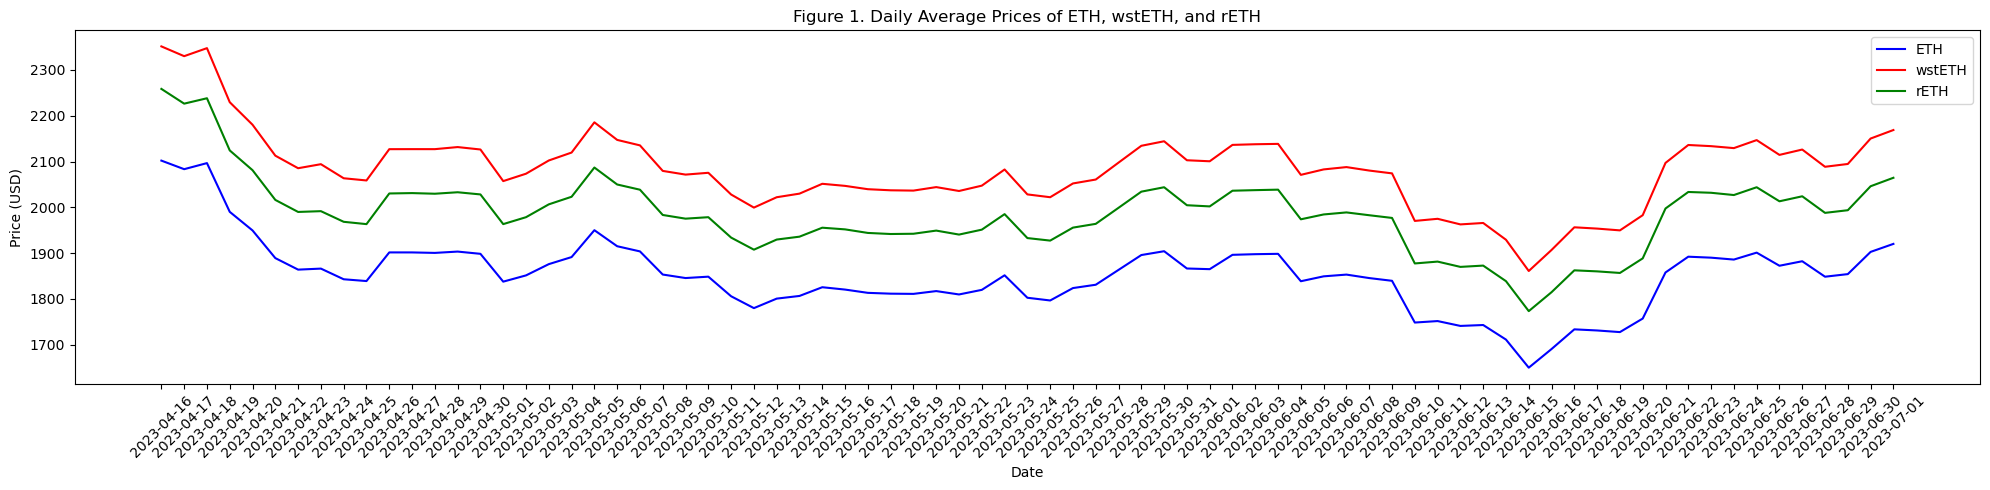

In [8]:
# Convert the dictionaries to lists for plotting
start_date = '2023-04-16'
dates = [date for date in eth_daily_average.keys() if date >= start_date]
eth_prices = [eth_daily_average[date] for date in dates]
wsteth_prices = [wsteth_daily_average[date] for date in dates]
reth_prices = [reth_daily_average.get(date, 0) for date in dates]  

# Plot the daily average prices
plt.figure(figsize=(10, 5)).set_figwidth(20)
plt.plot(dates, eth_prices, color='b', label='ETH')
plt.plot(dates, wsteth_prices, color='r', label='wstETH')
plt.plot(dates, reth_prices, color='g', label='rETH')  
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Figure 1. Daily Average Prices of ETH, wstETH, and rETH')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


